In [862]:
#import the necessary libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import eli5
from datetime import datetime
import warnings
import missingno as msno
from sklearn.neighbors import KernelDensity
warnings.filterwarnings('ignore')
% matplotlib inline

In [863]:
#import for modeling 
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.utils import resample
from sklearn.svm import SVC
import itertools

In [864]:
#load data
train=pd.read_csv('/Users/Elune/Desktop/spb/new/modeltrain.csv', dtype='str', sep=',')
#test=pd.read_csv('/Users/Elune/Desktop/spb/new/modeltest.csv', dtype='str', sep=',')

In [865]:
train.columns

Index(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy',
       'WnvSum', 'MosqSum', 'RowSum', 'day', 'week', 'CoordX', 'CoordY',
       'CoordZ', 'DisToWoods', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'CodeSum', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'DayLength', 'Humidity'],
      dtype='object')

In [866]:
train=train.rename(columns={'WnvSum':'WnvPresent'})

In [867]:
#train.dtypes

In [868]:
columns_to_convert = [ 'Latitude', 'Longitude', 'AddressAccuracy',
       'MosqSum', 'RowSum', 'CoordX', 'CoordY',
       'CoordZ', 'DisToWoods', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'DayLength', 'Humidity']

for col in columns_to_convert:
     train[col] = train[col].astype('float')

In [869]:
#standardize/scale the feature in order to check correlation

In [870]:
train=train.drop(columns=['MosqSum', 'Latitude', 'Longitude','Tmax', 'Tmin', 'StnPressure',
                     'WetBulb', 'ResultSpeed','Cool', 'DewPoint', 'day'])

## check if the class is balanced

In [871]:
train['WnvPresent'].value_counts()
# tune: class weight: n_samples / (n_classes * np.bincount(y))

0    8153
1     457
Name: WnvPresent, dtype: int64

In [872]:
def make_correlation_matrix(df):
    
    correlation = df.select_dtypes(include=[np.number]).corr()
    
    return correlation

correlation = make_correlation_matrix(train.loc[:, (train.columns!='Index')&(train.columns!='ID')])

In [873]:
print(np.abs(correlation['RowSum'].sort_values(ascending = False)))

RowSum             1.000000
Tavg               0.057571
DayLength          0.029422
Humidity           0.027158
DisToWoods         0.022396
SeaLevel           0.009342
PrecipTotal        0.019954
AvgSpeed           0.020491
ResultDir          0.020775
CoordZ             0.026062
CoordY             0.028009
Heat               0.029462
CoordX             0.043878
AddressAccuracy    0.074498
Name: RowSum, dtype: float64


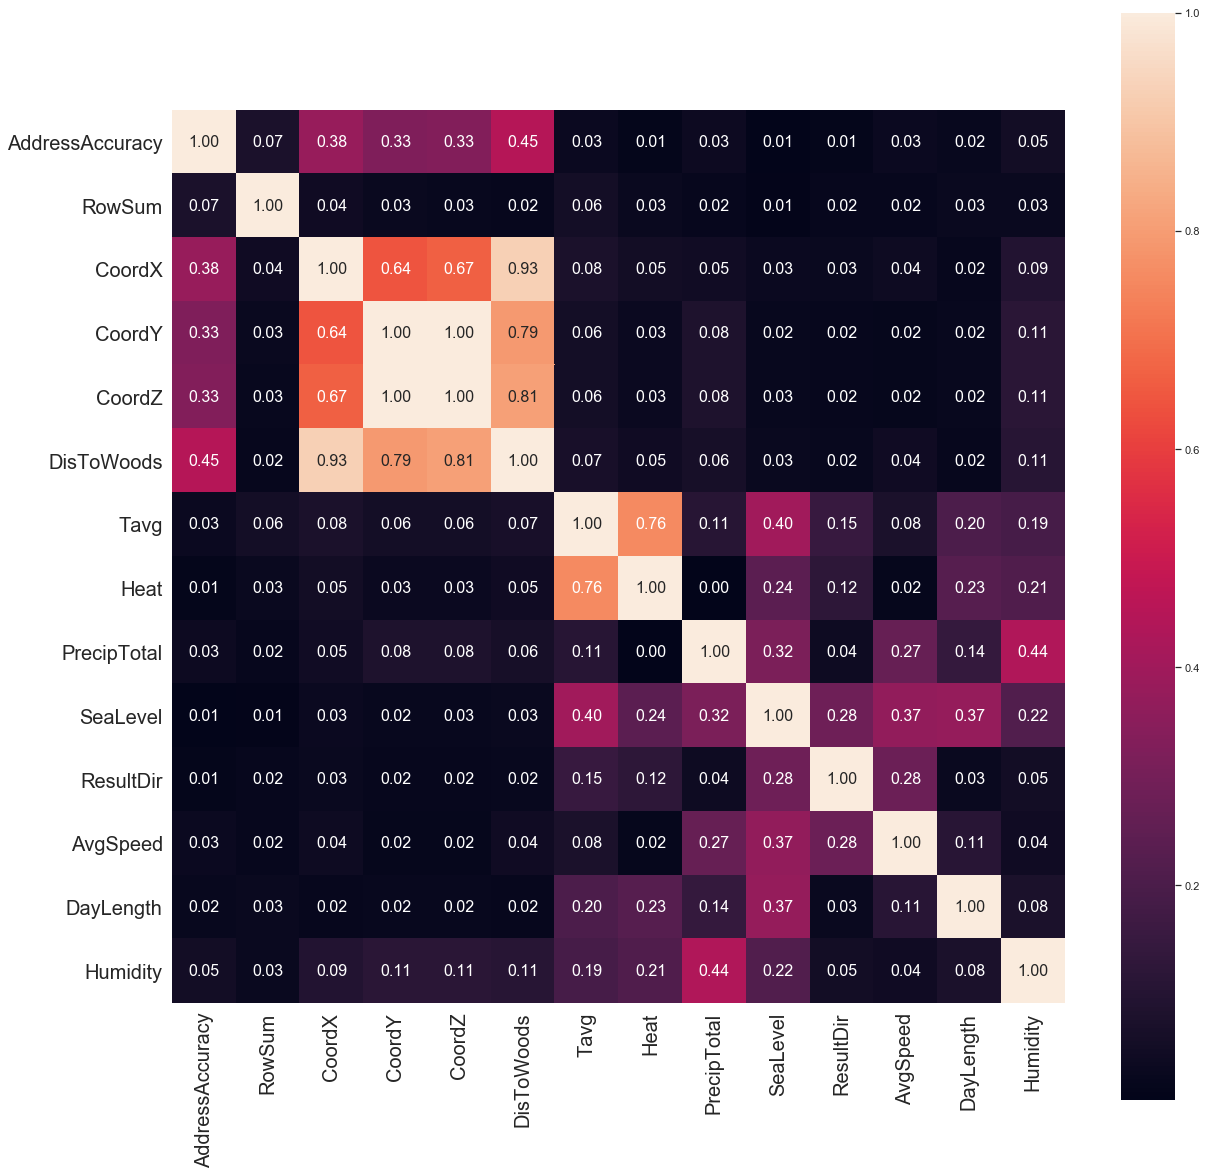

In [874]:
f , ax = plt.subplots(figsize = (20,20))
cols = abs(correlation).index
cor = train.loc[:, cols].select_dtypes(include = [np.number]).corr()
sns.heatmap(np.abs(cor),cbar=True,square = True,annot=True, fmt='.2f', annot_kws={'size': 16}, 
            yticklabels=cols.values, xticklabels=cols.values,)
plt.xticks(rotation=90,fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('correlation_map.png', bbox_inches='tight')

In [875]:
train.columns

Index(['Date', 'Species', 'Trap', 'AddressAccuracy', 'WnvPresent', 'RowSum',
       'week', 'CoordX', 'CoordY', 'CoordZ', 'DisToWoods', 'Tavg', 'Heat',
       'CodeSum', 'PrecipTotal', 'SeaLevel', 'ResultDir', 'AvgSpeed',
       'DayLength', 'Humidity'],
      dtype='object')

In [876]:
#engineer categorical variable
#train.Trap, mapping_index = pd.Series(train.Trap).factorize()
#dummize 'Species', 'CodeSum'
train = pd.concat([train, pd.get_dummies(train.Species, dtype=float)], axis=1)
train = pd.concat([train, pd.get_dummies(train.CodeSum, dtype=float)], axis=1)
train = pd.concat([train, pd.get_dummies(train.week, dtype=float)], axis=1)
#train = pd.concat([train, pd.get_dummies(train.day, dtype=float)], axis=1)

In [853]:
#train.dtypes

In [854]:
train.Date=pd.to_datetime(train.Date, infer_datetime_format=True)

## Train a Logistic Regression Model

In [887]:
train['WnvPresent'] = train['WnvPresent'].astype('int')
#train['day'] = train['day'].astype('int')
train['week'] = train['week'].astype('int')
tmp_df = train.drop(columns=['Species', 'CodeSum', 'Date', 'Trap'])
df = train.drop(columns=['Species', 'CodeSum', 'Date', 'Trap'])
#tmp_df.dtypes

In [897]:
def trainLogisticRegression(df):
    log = LogisticRegression(class_weight={0: 1, 1: 13})
    X = df.drop(['WnvPresent'], axis = 1)
    Y = df.loc[:, 'WnvPresent']
    # train test splitting
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=30)
    # Create an instance of Logistic Regression Classifier and fit the data.
    log.fit(X_train, Y_train)
    
    return X_train, Y_train, X_test, Y_test, log

X_train, Y_train, X_test, Y_test, log = trainLogisticRegression(tmp_df)
accuracy, auc_score, parameters = evaluateModel(log, X_test, Y_test)
print('Accuracy is ' + str(accuracy))
print('AUC score is ' + str(auc_score))


Accuracy is 0.7770034843205574
AUC score is 0.7314919852034526


In [891]:
#would downsample improve the performance? 
downsample = True
if downsample:
    # resample 
    df_majority = df[df.WnvPresent==1]
    df_minority = df[df.WnvPresent==0]
    # Upsample minority class
    from sklearn.utils import resample
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=1000,    # to match majority class
                                     random_state=123) # reproducible results
    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    # Display new class counts
    df_upsampled.WnvPresent.value_counts()
    X_train, Y_train, X_test, Y_test, log = trainLogisticRegression(df_upsampled)
    #accuracy, auc_score = evaluateModel(log, X_test, Y_test)
    print('Accuracy is ' + str(accuracy))
    print('AUC score is ' + str(auc_score))

Accuracy is 0.7526132404181185
AUC score is 0.742082195173975


In [893]:
importances = parameters.tolist()[0]
# multiply parameters by the standard deviation of each feature
# Combine a list of tuples with feature variable and importance
feature_importances = [(feature, importance) for feature, importance in zip(trainX, importances)]
# Sort feature importances by most important first
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

In [894]:
[print('Feature Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Feature Variable: 31                   Importance: 2.1635581310412846
Feature Variable: 29                   Importance: 2.153069287815444
Feature Variable: 30                   Importance: 1.9124291952588839
Feature Variable: DayLength            Importance: 1.7993407248901632
Feature Variable: 28                   Importance: 1.7809934511921721
Feature Variable: 26                   Importance: 1.661549940386797
Feature Variable: 32                   Importance: 1.5756101584829332
Feature Variable: Humidity             Importance: 1.5496863369214018
Feature Variable: 27                   Importance: 1.3341156354096775
Feature Variable: 33                   Importance: 1.2138549758009298
Feature Variable: CULEX ERRATICUS      Importance: 0.8792091314337239
Feature Variable: 34                   Importance: 0.7203136057963558
Feature Variable: 25                   Importance: 0.6857298480998198
Feature Variable: BR                   Importance: 0.6136639284345582
Feature Variable: week

#Use penalized learning algorithms through SVM, to increase the cost of classification mistakes on the minority class. 

In [895]:
def trainSVM(df):
    model = SVC(kernel='linear', 
            class_weight='balanced', # penalize
            probability=True)
    
    X = df.drop(['WnvPresent'], axis=1)
    Y = df.loc[:, 'WnvPresent']
    # train test splitting
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=30)

    # Create an instance of Logistic Regression Classifier and fit the data.
    model.fit(X_train, Y_train)
    
    return X_train, Y_train, X_test, Y_test, model
X_train, Y_train, X_test, Y_test, model = trainSVM (tmp_df)
print('Accuracy is ' +  str(accuracy))
print('AUC score is ' + str(auc_score))

Accuracy is 0.7526132404181185
AUC score is 0.742082195173975


## Random Forest

In [ ]:
def trainRF(df):
    model = RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 13}, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
    X = df.drop(['WnvPresent'], axis=1)
    Y = df.loc[:,'WnvPresent']
    # train test splitting
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    model.fit(X_train, Y_train)
    
    return X_train, Y_train, X_test, Y_test, model


(2, 2)
True negative is 93.30236159504453%
False positive is 22.422423982068647%
False negative is 93.22474524966431%
True positive is 79.29038822630156%
Accuracy is 0.9361207897793263
AUC score is 0.5218883126222704



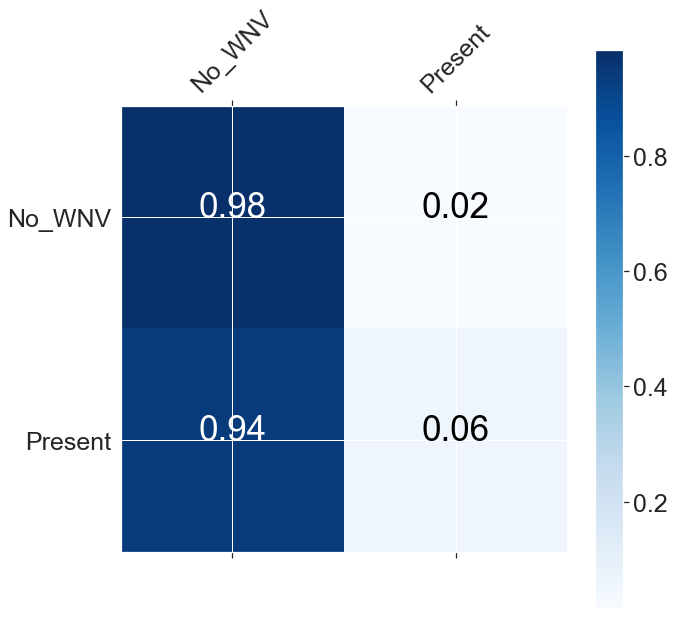

In [715]:
def trainRF(df):
    model = RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 13}, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
    X = df.drop(['WnvPresent'], axis=1)
    Y = df.loc[:,'WnvPresent']
    # train test splitting
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    model.fit(X_train, Y_train)
    
    return X_train, Y_train, X_test, Y_test, model

def evaluateRFModel(model, X_test, Y_test):
    predicted_classes = model.predict(X_test)
    accuracy = accuracy_score(Y_test,predicted_classes)
    auc_score = roc_auc_score(Y_test,predicted_classes)
    
    # obtain confusion matrix
    cm = confusion_matrix(Y_test, predicted_classes)
    print(cm.shape)
    tn, fp, fn, tp = cm.ravel()
    # normalize
    tn = tn/sum([tn, fp, fn, tp])
    fp = fp/sum([tn, fp, fn, tp])
    fn = fn/sum([tn, fp, fn, tp])
    tp = tp/sum([tn, fp, fn, tp])
    print('True negative is ' + str(tn*100) + '%')
    print('False positive is ' + str(fp*100) + '%')
    print('False negative is ' + str(fn*100) + '%')
    print('True positive is ' + str(tp*100) + '%')
    
    # plot the confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.matshow(cm, cmap=plt.cm.Blues)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=25)
    classes = ['No_WNV', 'Present']
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, classes, rotation=45, fontsize=25)
    plt.yticks(tick_marks, classes, fontsize=25)
    
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=35)
    plt.savefig('Confusion_matrix.png', bbox_inches='tight')
    return accuracy, auc_score

X_train, Y_train, X_test, Y_test, model = trainRF(tmp_df)
accuracy, auc_score = evaluateRFModel(model, X_test, Y_test)
print('Accuracy is ' + str(accuracy))
print('AUC score is ' + str(auc_score) + '\n')

In [573]:
param_grid_rf = {'n_estimators': [20, 50, 100, 250, 400, 500, 600, 700, 1000],
         'max_features': ['auto', 'sqrt'],
         'max_depth': [2, 5, 10, 20, 30, 40, 50],
         'min_samples_split': [3, 5, 7, 10, 15],
         'min_samples_leaf': [1, 2, 4],
         'bootstrap': [True, False]}

In [574]:
from sklearn.model_selection import RandomizedSearchCV
trainRF = RandomForestClassifier()
#create the RandomizedSearchCV object
grid_search_rf = RandomizedSearchCV(estimator=trainRF, param_distributions=param_grid_rf, n_iter=5, 
                                    cv=5, random_state=1, n_jobs=-1,)

In [575]:
grid_search_rf.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=-1,
          param_distributions={'n_estimators': [20, 50, 100, 250, 400, 500, 600, 700, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 5, 10, 20, 30, 40, 50], 'min_samples_split': [3, 5, 7, 10, 15], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [ ]:
#obtain hyperparameters used in the best model
print(grid_search_rf.best_params_)
print(grid_search_rf.best_score_)

#fine-tune the hyperparameters
grid_search_rf.fit(X_train, Y_train)
#get the best model
final_model_rf = grid_search_rf.best_estimator_
#obtain hyperparameters used in the best model
print(grid_search_rf.best_params_)
print(grid_search_rf.best_score_)

In [524]:
def feature_importance_built_in(trained_model, train_data):
    # Obtain feature importances
    importances = list(trained_model.feature_importances_)
    
    # Combine a list of tuples with feature variable and importance
    feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(train_data.columns.values, importances)]

    # Sort feature importances by most important first
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    
    return feature_importances, importances

feature_importances, importances = feature_importance_built_in(model, tmp_df.drop(['WnvPresent'], axis=1))

# Print
print('Below is a summary of feature importance: \n')
[print('Feature Variable: {:40} Importance: {}'.format(*pair)) for pair in feature_importances];

Below is a summary of feature importance: 

Feature Variable: CoordY                                   Importance: 0.1608
Feature Variable: CoordZ                                   Importance: 0.1591
Feature Variable: CoordX                                   Importance: 0.1576
Feature Variable: DisToWoods                               Importance: 0.152
Feature Variable: RowSum                                   Importance: 0.0748
Feature Variable: AddressAccuracy                          Importance: 0.0377
Feature Variable: CULEX PIPIENS/RESTUANS                   Importance: 0.0181
Feature Variable: ResultDir                                Importance: 0.0176
Feature Variable: SeaLevel                                 Importance: 0.0174
Feature Variable: AvgSpeed                                 Importance: 0.0169
Feature Variable: CULEX PIPIENS/RESTUANS                   Importance: 0.0167
Feature Variable: Humidity                                 Importance: 0.0164
Feature Variable: Dew

In [899]:
feature_col = tmp_df.drop(['WnvPresent'], axis = 1).dtypes.index

# create a dictionary storing features as key and importances as value
feature_importance_dict = {}
for ind in range(len(importances)):
    feature_importance_dict[feature_col[ind]] = importances[ind]
df_feature_importance = pd.Series(feature_importance_dict)
df_feature_importance = df_feature_importance.to_frame()
df_feature_importance.reset_index(inplace=True)
df_feature_importance.columns = ['feature', 'importance']
df_feature_importance.sort_values(by=['importance'], ascending=False, inplace=True)
sns.set(style="whitegrid")
sns.set(palette='pastel')
(pd.Series(model.feature_importances_, index=feature_col)
.nlargest(30)
   .plot(kind='barh'))
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(kind='barh') 
plt.xticks(rotation=90,fontsize=25)
plt.yticks(fontsize=20)
plt.xlabel('')
plt.ylabel('Feature importance', fontsize=30)
plt.savefig('Feature_importance_RF.png', bbox_inches='tight')

AttributeError: 'SVC' object has no attribute 'feature_importances_'

In [716]:
import xgboost as xgb
import numpy as np
from xgboost import plot_importance
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [906]:
def trainXGBoosting(df):
    xgb = XGBClassifier(learning_rate=0.2, seed=42, silent=1, n_estimators = 1000,)
    X = df.drop(['WnvPresent'], axis = 1)
    Y = df.loc[:, 'WnvPresent']
    # train test splitting
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=40)
    # Create an instance of Logistic Regression Classifier and fit the data.
    xgb.fit(X_train, Y_train)
    
    return X_train, Y_train, X_test, Y_test, xgb

In [905]:
X_train, Y_train, X_test, Y_test, xgb = trainXGBoosting(tmp_df)

In [719]:
def evaluateXGB(model, X_test, Y_test):
    predicted_classes = model.predict(X_test)
    accuracy = accuracy_score(Y_test,predicted_classes)
    auc_score = roc_auc_score(Y_test,predicted_classes)
    
    return accuracy, auc_score

accuracy, auc_score = evaluateXGB(xgb, X_test, Y_test)
print('Accuracy is ' + str(accuracy))
print('AUC score is ' + str(auc_score))

Accuracy is 0.9413472706155633
AUC score is 0.6025616326193606


In [908]:
importance = dict(zip(train.columns, xgb.feature_importances_ * 100 / max(xgb1.feature_importances_)))
#importance

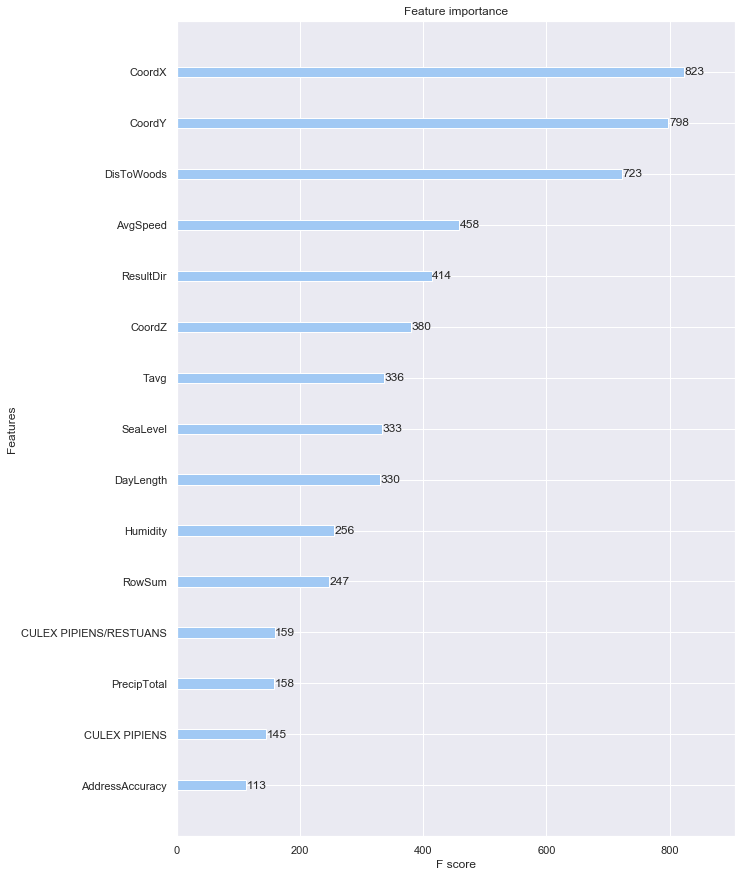

In [909]:
# plot feature importance
fig, ax = plt.subplots(figsize=(10, 15))
plot_importance(xgb, ax=ax,max_num_features=15)
plt.show()

#Conclusion: Both Logistic Regression (with Weight) and XGboost could be considered in current
scenario. Logistic Regression could perform better in generalizinng the prediction while xgboosting could fully capture the train set. The imbalanced class is the major concern that lead to the "overfitting" problem since neither gridsearch or randomsearch improved performance in random forest. Gaining more data in "class=1" level, adjust weight (maybe try Smote)and explore more features effectively might achieve the higher performance. 
